In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR 
from statsmodels.tsa.statespace.varmax import VARMAX
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2
import os

In [2]:
sales_data = pd.read_csv("D:\\MM\\lic-uek-dane\\train.csv")[:144]#first store and first department
features_data = pd.read_csv("D:\\MM\\lic-uek-dane\\features.csv")[:143]
figure_path = "..\\figures\\"

## Data overview

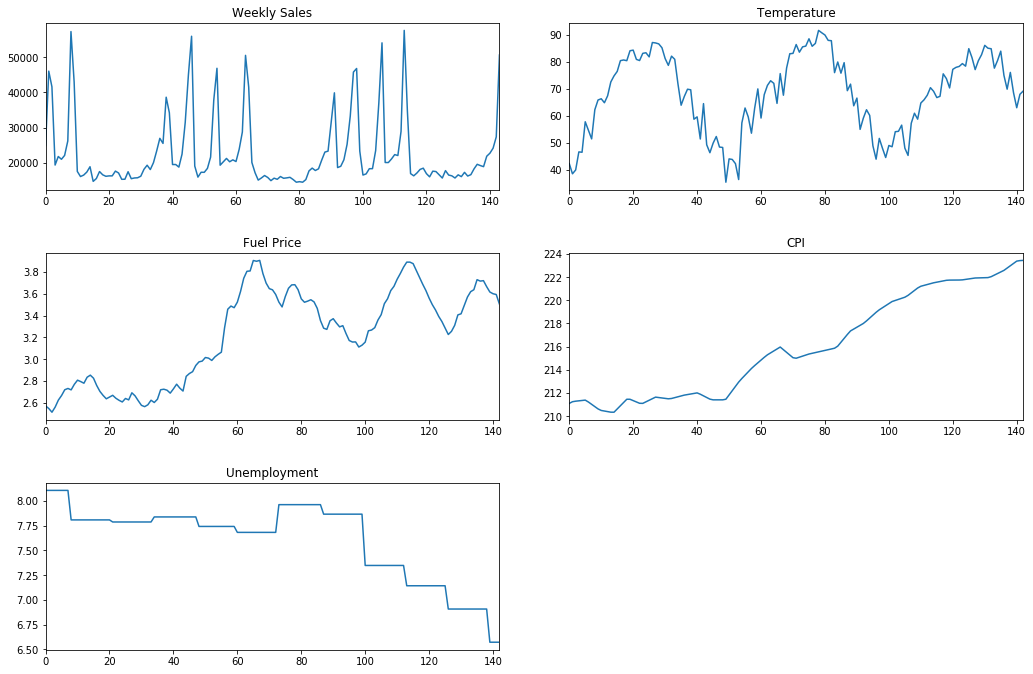

In [3]:
figure1 = plt.figure(figsize=(15,10))
plt.subplot(321)
sales_data["Weekly_Sales"].plot()
plt.title("Weekly Sales")

plt.subplot(322)
features_data["Temperature"].plot()
plt.title("Temperature")

plt.subplot(323)
features_data["Fuel_Price"].plot()
plt.title("Fuel Price")

plt.subplot(324)
features_data["CPI"].plot()
plt.title("CPI")

plt.subplot(325)
features_data["Unemployment"].plot()
plt.title("Unemployment")

figure1.tight_layout(pad=3.0)


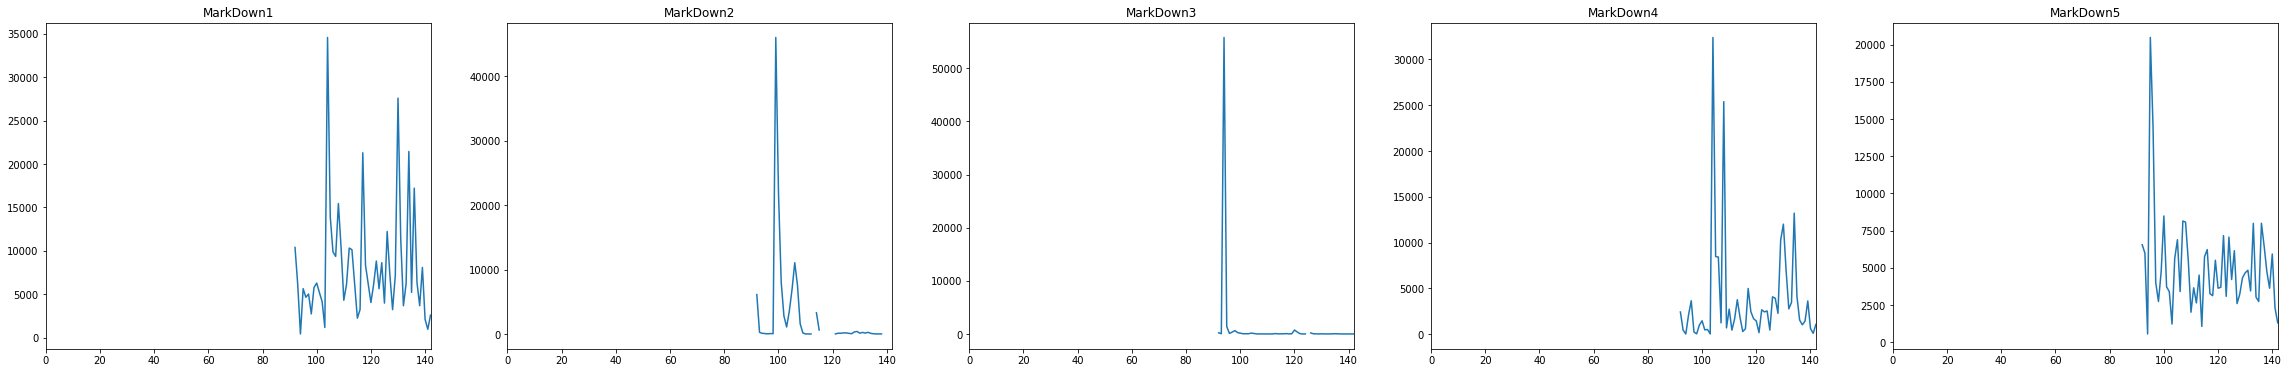

In [4]:
plt.figure(figsize=(40,6))
for i in range(1,6):
    plt.subplot(1,5,i)
    features_data["MarkDown"+str(i)].plot()
    plt.title("MarkDown"+str(i))

In [5]:
features_data

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
138,1,2012-09-28,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,222.981658,6.908,False
139,1,2012-10-05,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,223.181477,6.573,False
140,1,2012-10-12,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,223.381296,6.573,False
141,1,2012-10-19,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,223.425723,6.573,False


In [6]:
sales_data.tail()###generally we have 143 obs

,Store,Dept,Date,Weekly_Sales,IsHoliday
139,1,1,2012-10-05,21904.47,False
140,1,1,2012-10-12,22764.01,False
141,1,1,2012-10-19,24185.27,False
142,1,1,2012-10-26,27390.81,False
143,1,2,2010-02-05,50605.27,False


## Functions

In [4]:
def scaler(arr):
    mini = min(arr)
    maxi = max(arr)
    return (arr - mini) / (maxi - mini)

def plot_two(dep_1, dep_2, scaled = False, legend_38_40 = True):
    ts1 = sales_data[sales_data["Dept"] == dep_1]["Weekly_Sales"]
    ts2 = sales_data[sales_data["Dept"] == dep_2]["Weekly_Sales"]
    if scaled:
        ts1 = scaler(ts1)
        ts2 = scaler(ts2)
    
    fig = plt.figure(figsize = (40,10))
    plt.plot(range(N),ts1, color = "red", linewidth = 5)
    plt.plot(range(N),ts2, color = "green", linewidth = 5)
    if legend_38_40:
        plt.legend(labels = ["Prescription Pharmacy", "OTC Pharmacy"], loc = "upper right", fontsize = 24)
    if not legend_38_40:
        plt.legend(labels = ["dep "+str(dep_1), "dep "+str(dep_2)], loc = "upper right", fontsize = 24)

    



In [5]:
def residuals_analysis(model):
    residuals = model.resid.T
    #print(residuals.shape)
    #print(residuals[0])
    plt.figure(figsize = (20,8))
    stats.probplot(residuals[0], dist="norm", plot=plt.subplot(121))
    plt.title("Prescription Pharmacy", size = 25)
    stats.probplot(residuals[1], dist="norm", plot=plt.subplot(122))
    plt.title("OTC Pharmacy", size = 25)
    plt.show()
    
    plt.figure(figsize = (20,18))
    plt.subplot(221)
    plt.plot(residuals[0], ".", markersize = 20)
    plt.axhline(0, color = "red", lw = 3)
    plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
    plt.title("Prescription Pharmacy", size = 25)
    plt.subplot(222)
    plt.plot(residuals[1], ".", markersize = 20)
    plt.axhline(0, color = "red", lw = 3)
    plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
    plt.title("OTC Pharmacy", size = 25)
    plt.subplot(223)
    sns.distplot(residuals[0], bins = 20)
    plt.title("Prescription Pharmacy", size = 25)
    plt.subplot(224)
    sns.distplot(residuals[1], bins = 20)
    plt.title("OTC Pharmacy", size = 25)
    plt.show()
    


In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey

def stat_tests_resid(model):
    residuals = model.resid.T
    print("Prescription Pharmacy, H0: data comes from normal distribution")
    print("shapiro pvalue =", stats.shapiro(residuals.iloc[0])[1])
    print("omnibus pvalue =", stats.normaltest(residuals.iloc[0])[1])
    print("OTC Pharmacy, H0: data comes from normal distribution")
    print("shapiro pvalue =", stats.shapiro(residuals.iloc[1])[1])
    print("omnibus pvalue =", stats.normaltest(residuals.iloc[1])[1])
    #print("breusch_godfrey (LM) test, H0: Autocorrelation is equal to 0")
    print("Prescription Pharmacy ljung-box pvalue =", acorr_ljungbox(residuals.iloc[0], lags = 10)[1])
    print("OTC Pharmacy ljung-box pvalue =", acorr_ljungbox(residuals.iloc[1], lags = 10)[1])
    # acorr_breusch_godfrey
    



In [7]:
def rolling_window(X, training_len = 104, var_order = 4, window_size = 1, plot = True,var = True, exog_data = None,
                  plt_save_path = None):
    obs_left = X.shape[0] - training_len + var_order
    #print(obs_left)
    data = X[:training_len-var_order,]
    exog = exog_data[:training_len-var_order,]
    y_hat = pd.DataFrame({"Prescription Pharmacy":np.zeros(obs_left), "OTC Pharmacy":np.zeros(obs_left)})
    #print(X.shape, data.shape)
    
    for i in range(1,obs_left + 1):
        if var:
            model = VAR(endog = data, exog = exog).fit(0, trend = "nc")
            params = model.params
            vals = exog_data[training_len-var_order+i-1]
            y_hat.iloc[i-1,:] = params.T @ vals
        
        data = X[:training_len - var_order +i,]
        exog = exog_data[:training_len-var_order+i,]
        
    if plot:
        plt.figure(figsize = (20,10))
        plt.plot(y_hat, lw = 6)
        plt.plot(X[training_len-var_order:,], lw = 3)
        plt.legend(labels = ["Prescription Pharmacy forecast", "OTC Pharmacy forecast", "Prescription Pharmacy",
                         "OTC Pharmacy"], fontsize = 18)
        plt.savefig(plt_save_path)
        plt.show()
        return y_hat


    

In [8]:
#czy redukcja z modelu2 do modelu 1 jest zasadna:
def lr_test(model1_fitted, model2_fitted):
    l1 = model1_fitted.llf
    l2 = model2_fitted.llf
    df = abs(model1_fitted.df_model - model2_fitted.df_model)
    return 1 - chi2.cdf(2 * abs(l1 - l2), df)


## Variables (adding 0-1 months representation, etc)

In [9]:
N = 143 #number of observations
sales_data = pd.read_csv("D:\\MM\\lic-uek-dane\\train.csv")[:10244]
d38 = sales_data[sales_data["Dept"] == 38]
d40 = sales_data[sales_data["Dept"] == 40]
holidays = features_data["IsHoliday"]

TRAIN_SIZE = 104
TEST_SIZE = N - TRAIN_SIZE
x1, x2 = d38["Weekly_Sales"].values / 1000, d40["Weekly_Sales"].values / 1000
holidays = holidays.values
x1x2 = x1 * x2
x1_kw = x1 * x1 
x2_kw = x2 * x2
endog = pd.DataFrame({"Prescription Pharmacy": x1, "OTC Pharmacy": x2},
                columns = ["Prescription Pharmacy", "OTC Pharmacy"])

endog_train = endog.iloc[:TRAIN_SIZE,:]
endog_test = endog.iloc[TRAIN_SIZE:,:]



second_order = pd.DataFrame([x1_kw, x2_kw, x1x2]).T
second_order.columns = ["Prescription^2", "OTC^2", "Prescription*OTC"]

months_onehot = np.zeros(shape = (143, 12))#january will be (later on) the reference month
dates = d40["Date"].values
months = [int(dates[i][5:7])  if dates[i][5:7][0] != str(0) else int(dates[i][6]) for i in range(len(dates))]
for i in range(143):
    months_onehot[i, months[i]-1] = 1

#in order to avoid collinearity first column will be removed
months_onehot = np.delete(months_onehot, obj = 0, axis = 1) #axis = 1 means column

### Basic plot 

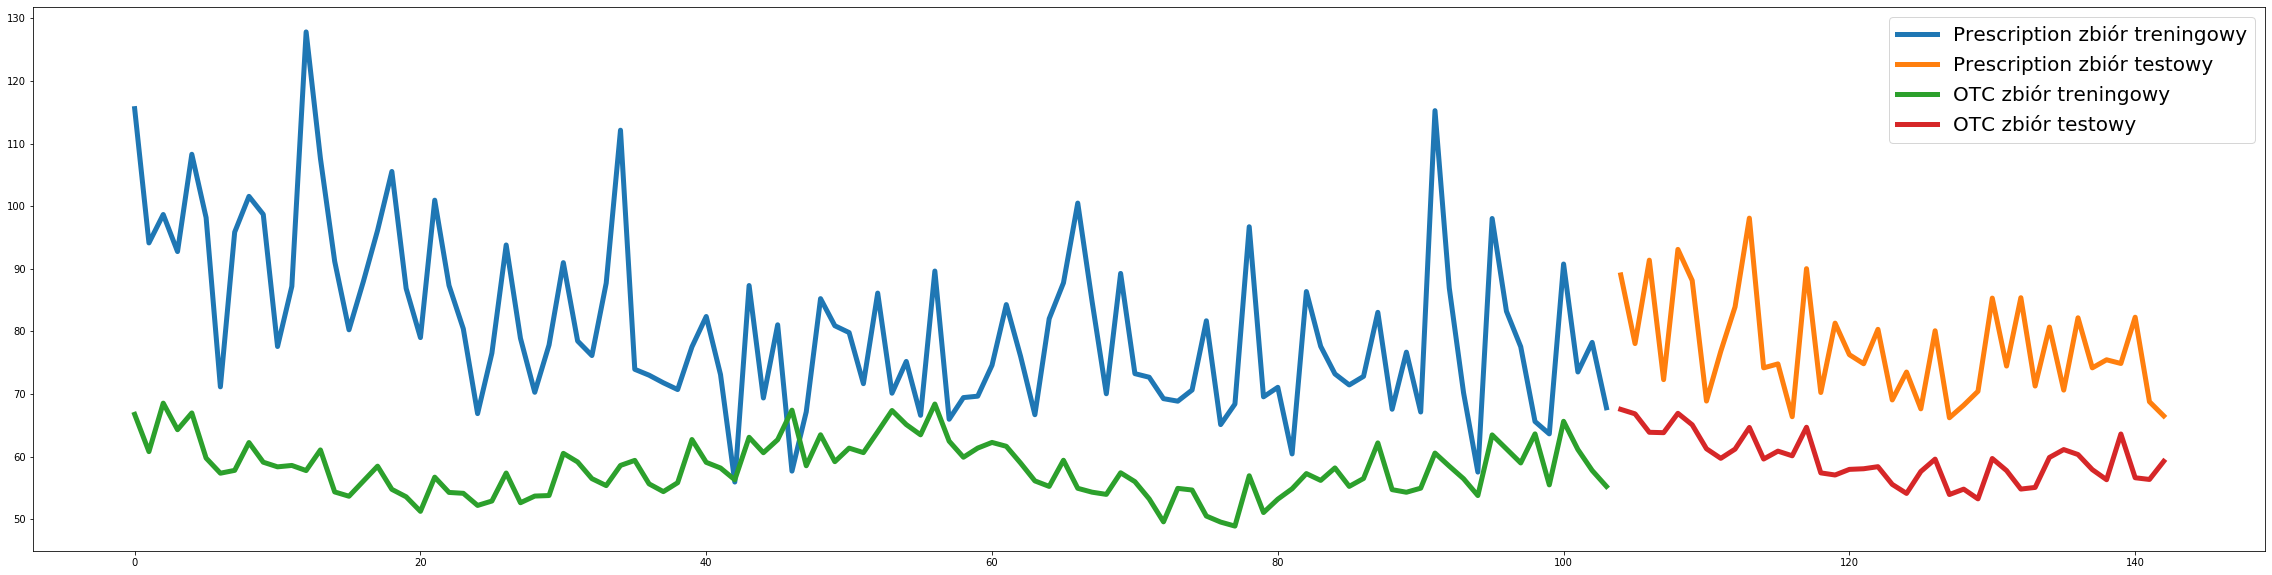

In [13]:
cut = 104
a = x1[:cut]
b = x1[cut:]
c = x2[:cut]
d = x2[cut:]
fig = plt.figure(figsize = (40,10))
#plt.plot(range(N),ts1, color = "red", linewidth = 5)
#plt.plot(range(N),ts2, color = "green", linewidth = 5)
plt.plot(a, linewidth = 5)
plt.plot([None for i in a] + [i for i in b], linewidth = 5)
plt.plot(c, linewidth = 5)
plt.plot([None for i in c] + [i for i in d], linewidth = 5)
plt.legend(labels = ["Prescription zbiór treningowy", "Prescription zbiór testowy", 
                     "OTC zbiór treningowy", "OTC zbiór testowy", ], loc = "upper right", fontsize = 20)
plt.savefig(figure_path + "otc_prescription.png")



### ADF test

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
adfuller(x1[:cut],regression = "ct", maxlag = 4)[1], adfuller(x1)[1], adfuller(x2[:cut], maxlag = 4)[1], adfuller(x2)[1]

(0.21892304781308286,
 0.012332290425892211,
 0.1482788466673014,
 0.02051673050648087)

### Statystyki opisowe, histogramy

In [18]:
from scipy.stats import skew, kurtosis
for i in [x1[:cut], x1, x2[:cut], x2]:
    print(np.quantile(i, 0.25), np.median(i), np.quantile(i, 0.75),np.mean(i), np.std(i), skew(i), kurtosis(i))



70.56993 78.05844 87.8055475 80.97142519230769 13.651806113524163 0.8529171381695406 0.6285052573223915
70.55125000000001 77.56796 87.27211 79.97822258741259 12.497022586590122 0.9880188480539461 1.1651129301676217
54.877660000000006 57.81279 61.116452499999994 58.1052785576923 4.3457664652524 0.34974554970969685 -0.3116686890733842
55.19342 58.21446 61.197694999999996 58.51040916083915 4.249142602349161 0.3015197722299193 -0.36018667457757303


Text(0.5, 1.0, 'Histogram dla OTC (cały zbiór)')

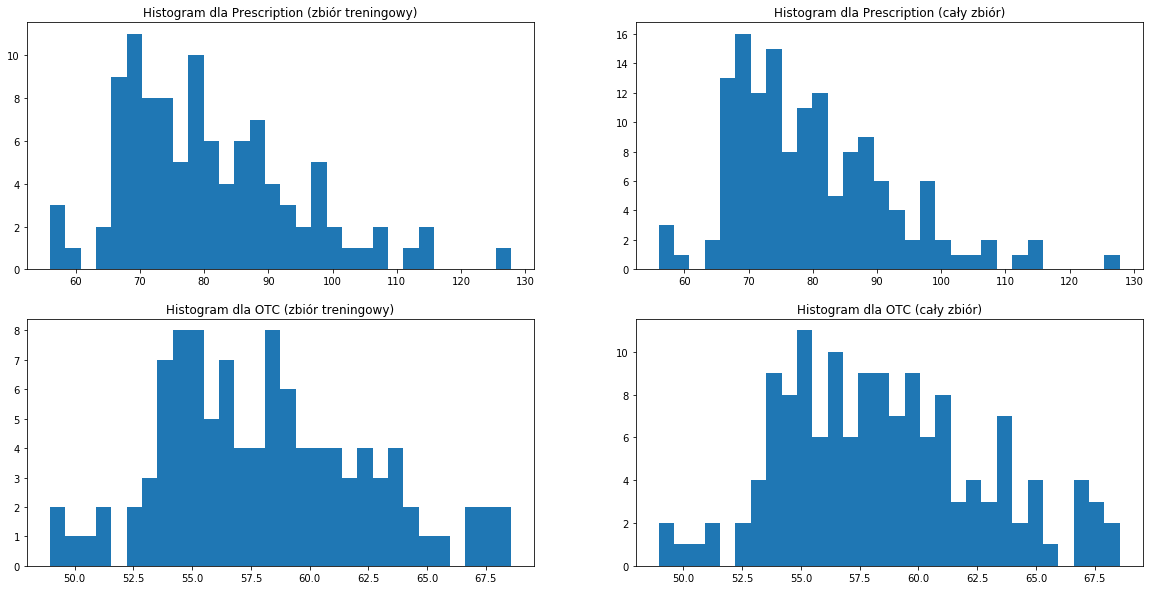

In [19]:
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.hist(x1[:cut], bins = 30)
plt.title("Histogram dla Prescription (zbiór treningowy)")
plt.subplot(222)
plt.hist(x1, bins = 30)
plt.title("Histogram dla Prescription (cały zbiór)")
plt.subplot(223)
plt.hist(x2[:cut], bins = 30)
plt.title("Histogram dla OTC (zbiór treningowy)")
plt.subplot(224)
plt.hist(x2, bins = 30)
plt.title("Histogram dla OTC (cały zbiór)")

### Rząd modelu VAR

Choosen orders: aic --> 16 bic --> 4 hqic --> 4


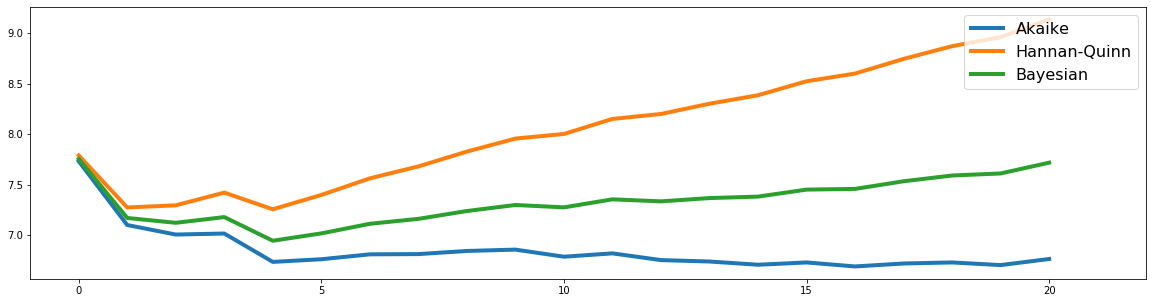

In [20]:
model = VAR(endog_train)
orders = model.select_order(maxlags = 20)
ic_dict = orders.ics
orders_ints = orders.selected_orders
print("Choosen orders: aic -->", orders_ints["aic"], "bic -->", orders_ints["bic"], "hqic -->", orders_ints["hqic"])
plt.figure(figsize = (20,5))
plt.plot(range(21), ic_dict["aic"], lw = 4)
plt.plot(range(21),ic_dict["bic"], lw = 4)
plt.plot(range(21),ic_dict["hqic"], lw = 4)
plt.legend(labels = ["Akaike", "Hannan-Quinn", "Bayesian"], loc = "upper right", fontsize = 16)
plt.xlim(-1,22)
plt.savefig(figure_path + "var_order.png")
plt.show()

### Przygotowanie zmiennych

In [21]:
yp = x1[4:] 
yo = x2[4:] 
const = np.ones(shape = (N-4))
xp1 = x1[3:-1]
xp2 = x1[2:-2]
xp3 = x1[1:-3]
xp4 = x1[:-4]
xo1 = x2[3:-1]
xo2 = x2[2:-2]
xo3 = x2[1:-3]
xo4 = x2[:-4]
X1 = np.array([const, xp1, xo1, xp2, xo2, xp3, xo3, xp4, xo4]).T
X2 = np.concatenate((np.array([const, xp1, xo1, xp2, xo2, xp3, xo3, xp4, xo4, holidays[4:]]).T,
                    months_onehot[4:,]), axis = 1)
#X3 = np.array([np.ones(shape = (N-1)), x1[:-1], x2[:-1], x1_kw[:-1], x1x2[:-1], x2_kw[:-1]]).T

X4 = np.concatenate((X2, np.array([ x1_kw[:-4], x1x2[:-4], x2_kw[:-4]]).T), axis = 1)


## Estymacja modeli VAR z rozszerzeniami i bez

In [23]:
# model VAR(4)
model1 = VAR(endog_train).fit(4)
# VAR(4) ze swietami i miesiacami
model2 = VAR(endog.values[4:TRAIN_SIZE,], exog = X2[:TRAIN_SIZE-4,]).fit(0, trend = "nc")
# VAR(1) z kwadratami i iloczynem zmiennych (efekty drugiego rzedu) 
#model3 = VAR(endog.values[1:TRAIN_SIZE,], exog = X3[:TRAIN_SIZE-1,]).fit(0, trend = "nc")
#
"""
model1_varmax = VARMAX(endog = endog_train, order = (4,0)).fit()
model2_varmax = VARMAX(endog = endog_train, order = (4,0), 
                       exog = np.concatenate((months_onehot[:TRAIN_SIZE,], holidays[:TRAIN_SIZE].reshape(TRAIN_SIZE,1)), 
                                             axis = 1)).fit(maxiter = 200, method = "powell")
"""
# model VAR(4) ze swietami, miesiacami, oraz kwadratami zmiennych opozninych o 4 okresy
model4 = VAR(endog.values[4:TRAIN_SIZE,], exog = X4[:TRAIN_SIZE-4,]).fit(0, trend = "nc")

In [ ]:
modelx = VAR(endog.values[4:TRAIN_SIZE,], exog = X1[:TRAIN_SIZE-4,]).fit(0, trend = "nc")
modelx.summary()

In [ ]:
# test lr wskazuje ze model z kwadratami (przy zmiennej opoznionej o 4 okersy) moze byc bardziej sensowny
# niz model bez kwadratow
lr_test(model2, model4)

### VAR(4) zwykly (estymacja, analiza reszt)

In [24]:
# model VAR(4)
model1 = VAR(endog_train).fit(4)
model1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Apr, 2021
Time:                     17:45:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.39630
Nobs:                     100.000    HQIC:                   7.11715
Log likelihood:          -612.156    FPE:                    1020.80
AIC:                      6.92737    Det(Omega_mle):         859.189
--------------------------------------------------------------------
Results for equation Prescription Pharmacy
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           33.079722        20.024292            1.652           0.099
L1.Prescription Pharmacy         0.300839         0.093568            3.215           0.001


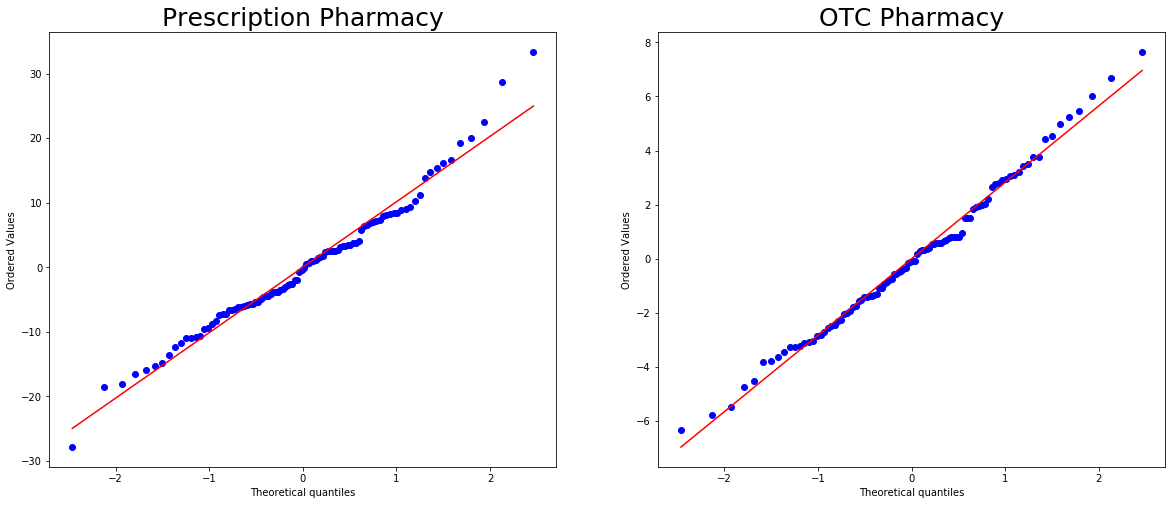

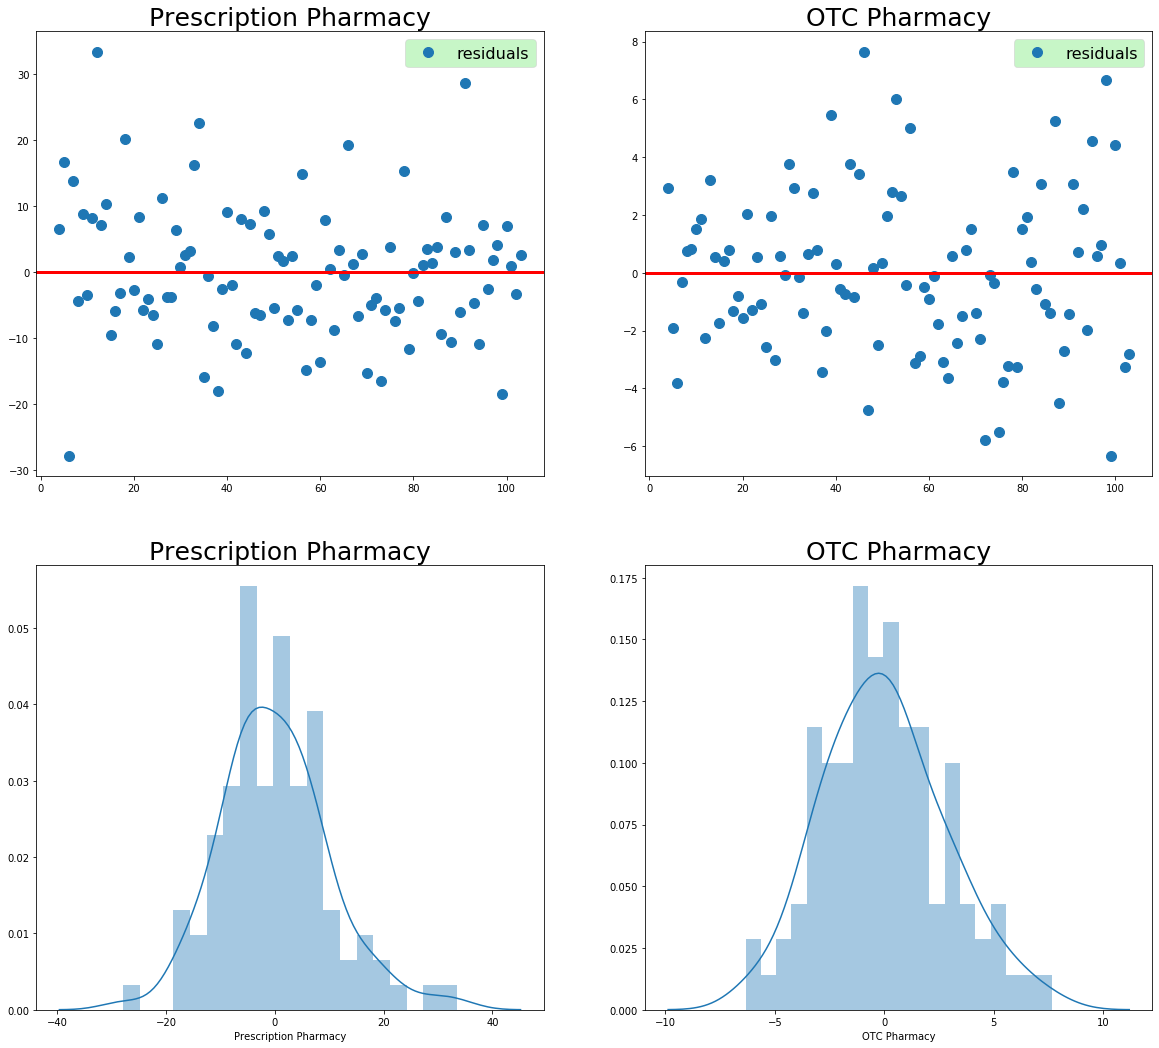

Prescription Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.11498472839593887
omnibus pvalue = 0.02425344975552706
OTC Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.6906628012657166
omnibus pvalue = 0.45001891779136993
Prescription Pharmacy ljung-box pvalue = [0.12077697 0.26466919 0.44729424 0.46388829 0.59914872 0.6963088
 0.74459065 0.79800313 0.82463356 0.82022078]
OTC Pharmacy ljung-box pvalue = [0.58130524 0.8458187  0.58962989 0.75041699 0.83579972 0.88443201
 0.93556738 0.95038815 0.94150109 0.96547199]


c:\users\mmarz\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [25]:
residuals = model1.resid.T
plt.figure(figsize = (20,8))
stats.probplot(residuals.iloc[0], dist="norm", plot=plt.subplot(121))
plt.title("Prescription Pharmacy", size = 25)
stats.probplot(residuals.iloc[1], dist="norm", plot=plt.subplot(122))
plt.title("OTC Pharmacy", size = 25)
plt.savefig(figure_path + "qqplot_var4_zwykly.jpg")
plt.show()
    
plt.figure(figsize = (20,18))
plt.subplot(221)
plt.plot(residuals.iloc[0], ".", markersize = 20)
plt.axhline(0, color = "red", lw = 3)
plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
plt.title("Prescription Pharmacy", size = 25)
plt.subplot(222)
plt.plot(residuals.iloc[1], ".", markersize = 20)
plt.axhline(0, color = "red", lw = 3)
plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
plt.title("OTC Pharmacy", size = 25)
plt.subplot(223)
sns.distplot(residuals.iloc[0], bins = 20)
plt.title("Prescription Pharmacy", size = 25)
plt.subplot(224)
sns.distplot(residuals.iloc[1], bins = 20)
plt.title("OTC Pharmacy", size = 25)
plt.savefig(figure_path + "reszty_var4_zwykly.jpg")
plt.show()

stat_tests_resid(model1)

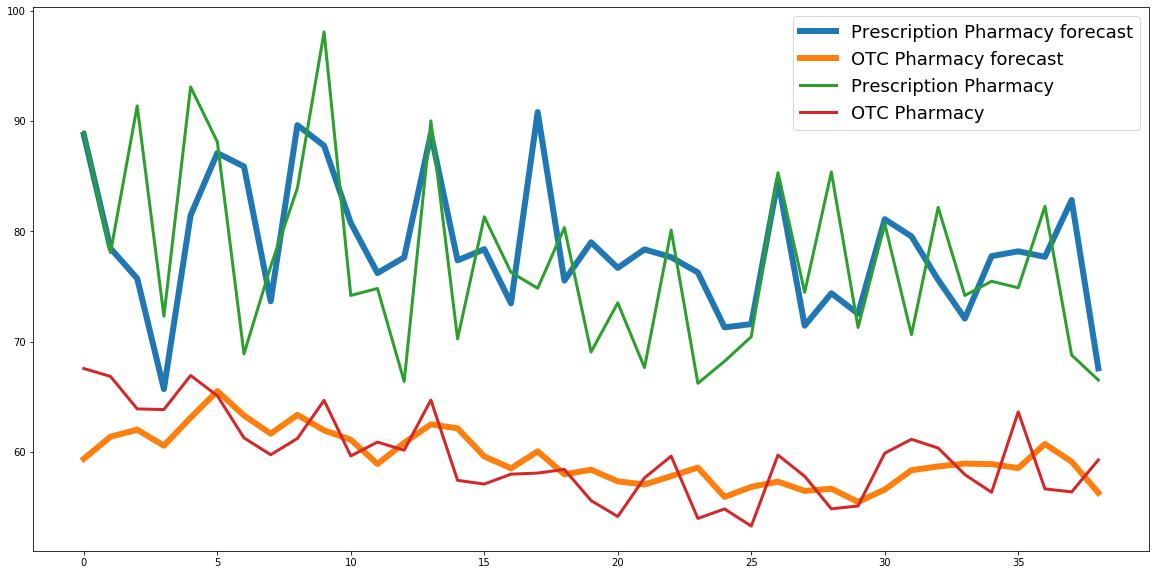

In [26]:
forecasts1 = rolling_window(X = endog.values[4:,], var = True, exog_data = X1,
                            plt_save_path = figure_path + "var4_zwykly_rolling_window.png")

### VAR(4) ze zmeinnymi zero-jedynkowymi

In [27]:
X = pd.DataFrame(np.concatenate((holidays[:TRAIN_SIZE].reshape(-1,1), months_onehot[:TRAIN_SIZE]), axis = 1),
                 columns = ["holidays","February", "March", "April", "May", "June", "July", "August", "September",
                     "October", "November", "December",])

model2 = VAR(endog_train, exog = X).fit(4)
model2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Apr, 2021
Time:                     17:45:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.99792
Nobs:                     100.000    HQIC:                   7.34658
Log likelihood:          -586.975    FPE:                    1008.72
AIC:                      6.90375    Det(Omega_mle):         688.966
--------------------------------------------------------------------
Results for equation Prescription Pharmacy
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                          126.531125        62.707783            2.018           0.044
holidays                        -9.079916         4.749683           -1.912           0.056


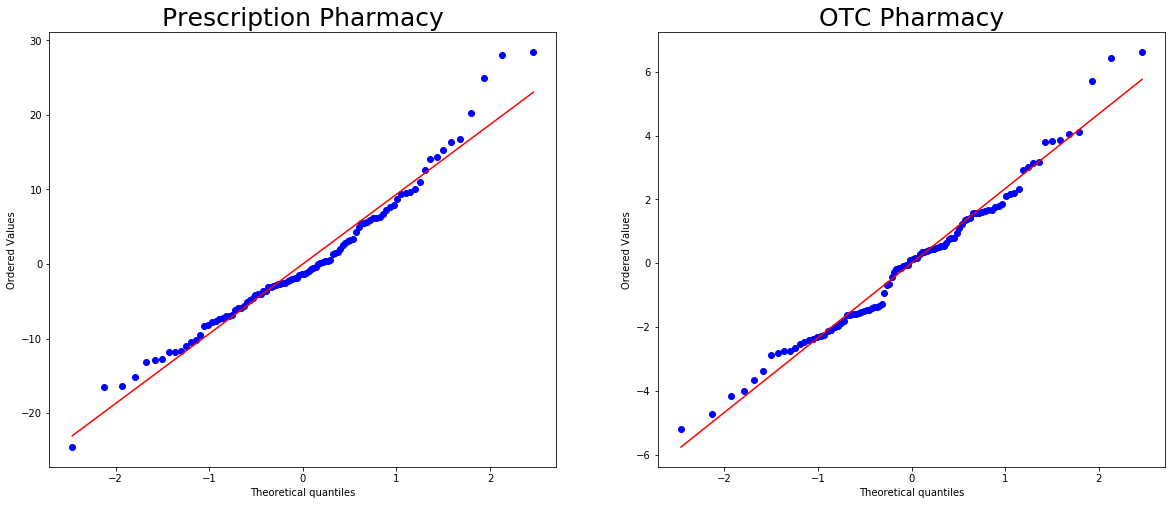

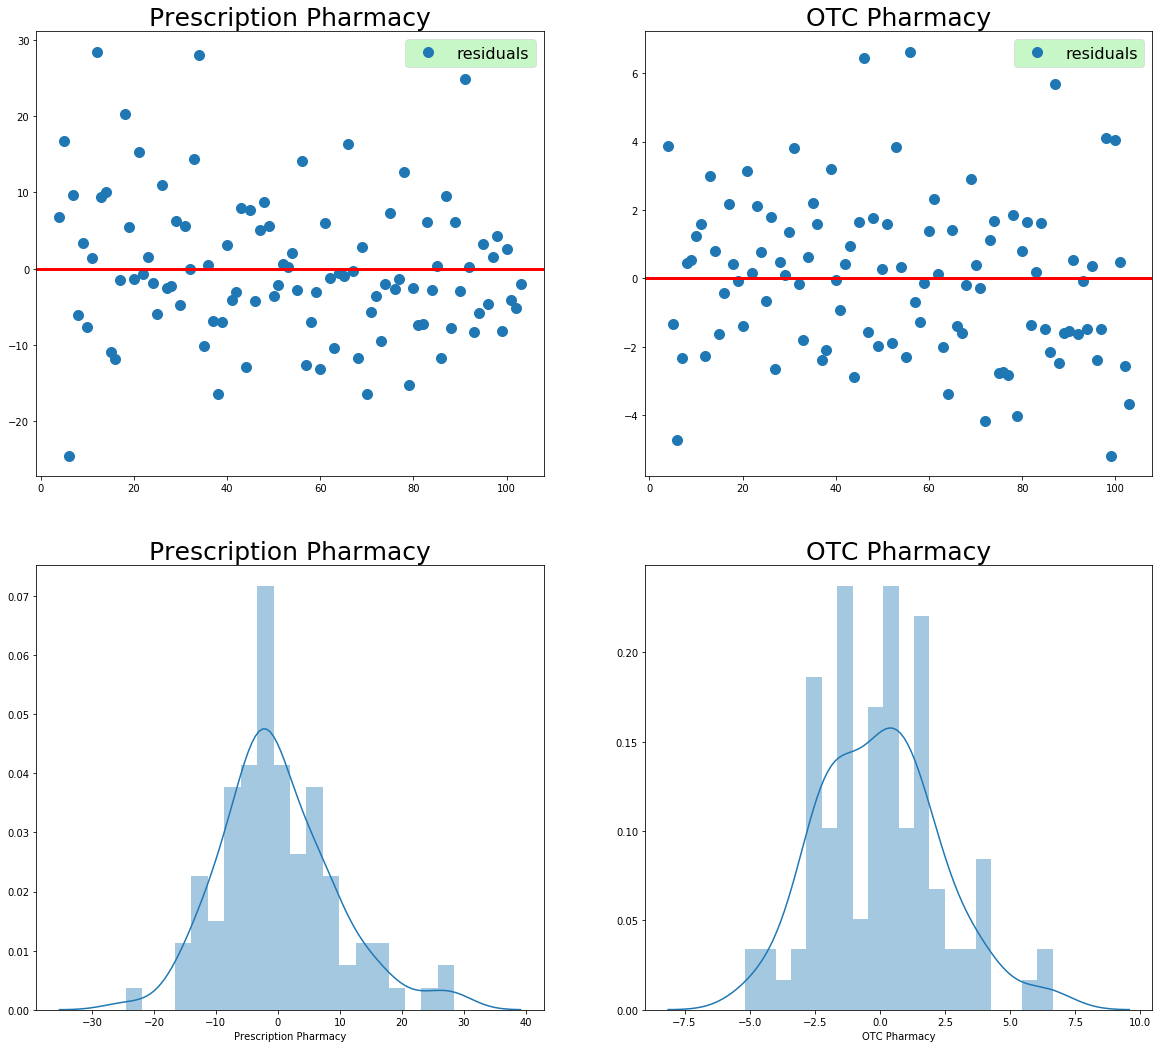

Prescription Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.01986214891076088
omnibus pvalue = 0.007667917217253242
OTC Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.1593891978263855
omnibus pvalue = 0.17789129560600966
Prescription Pharmacy ljung-box pvalue = [0.33918132 0.58167679 0.74258578 0.37680331 0.51087569 0.619179
 0.67910846 0.74577335 0.66021104 0.6647912 ]
OTC Pharmacy ljung-box pvalue = [0.05592692 0.0332025  0.05381144 0.10221672 0.15694359 0.23045906
 0.29891145 0.39434644 0.46128043 0.53613389]


In [28]:
residuals = model2.resid.T
plt.figure(figsize = (20,8))
stats.probplot(residuals.iloc[0], dist="norm", plot=plt.subplot(121))
plt.title("Prescription Pharmacy", size = 25)
stats.probplot(residuals.iloc[1], dist="norm", plot=plt.subplot(122))
plt.title("OTC Pharmacy", size = 25)
plt.savefig(figure_path + "qqplot_var4_dummy.jpg")
plt.show()
    
plt.figure(figsize = (20,18))
plt.subplot(221)
plt.plot(residuals.iloc[0], ".", markersize = 20)
plt.axhline(0, color = "red", lw = 3)
plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
plt.title("Prescription Pharmacy", size = 25)
plt.subplot(222)
plt.plot(residuals.iloc[1], ".", markersize = 20)
plt.axhline(0, color = "red", lw = 3)
plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
plt.title("OTC Pharmacy", size = 25)
plt.subplot(223)
sns.distplot(residuals.iloc[0], bins = 20)
plt.title("Prescription Pharmacy", size = 25)
plt.subplot(224)
sns.distplot(residuals.iloc[1], bins = 20)
plt.title("OTC Pharmacy", size = 25)
plt.savefig(figure_path + "reszty_var4_dummy.jpg")
plt.show()

stat_tests_resid(model2)

In [29]:
#czy kuroza empirycznego rozkladu reszt jest rowna 0 (czy mamy rozklad normalny)?
kurtosis(model2.resid)

NameError: name 'kurtosis' is not defined

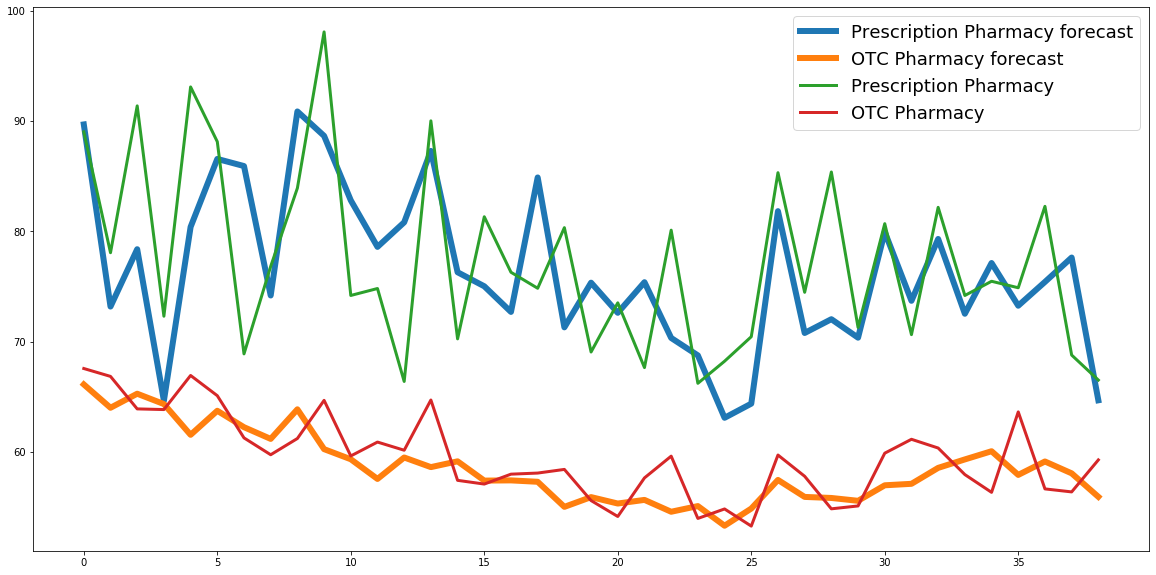

In [30]:
forecasts2 = rolling_window(X = endog.values[4:,], var = True, exog_data = X2,
                            plt_save_path = figure_path + "var4_dummy_rolling_window.png")

## Model VAR(4) z rozszerzeniami i uwzględnieniem nieliniowości

In [31]:
X = np.concatenate((holidays[:TRAIN_SIZE].reshape(-1,1), months_onehot[:TRAIN_SIZE]), axis = 1)
x1kw = np.concatenate((np.zeros((4,1)), x1_kw[:TRAIN_SIZE-4].reshape(-1,1)), axis = 0)
x1_x2 = np.concatenate((np.zeros((4,1)), x1x2[:TRAIN_SIZE-4].reshape(-1,1)), axis = 0)
x2kw = np.concatenate((np.zeros((4,1)), x2_kw[:TRAIN_SIZE-4].reshape(-1,1)), axis = 0)
nonlinearity = np.concatenate((x1kw, x1_x2, x2kw), axis = 1)
X = pd.DataFrame(np.concatenate((X, nonlinearity), axis = 1), 
                 columns = ["holidays","February", "March", "April", "May", "June", "July", "August", "September",
                     "October", "November", "December","L4.Prescription_square", "L4.Prescription_OTC",
                           "L4.OTC_square"])

model4 = VAR(endog_train, exog = X).fit(4)
model4.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Apr, 2021
Time:                     17:45:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.12414
Nobs:                     100.000    HQIC:                   7.37975
Log likelihood:          -579.471    FPE:                    985.111
AIC:                      6.87366    Det(Omega_mle):         640.681
--------------------------------------------------------------------
Results for equation Prescription Pharmacy
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                         -304.931168       199.949690           -1.525           0.127
holidays                        -7.800977         4.665883           -1.672           0.095


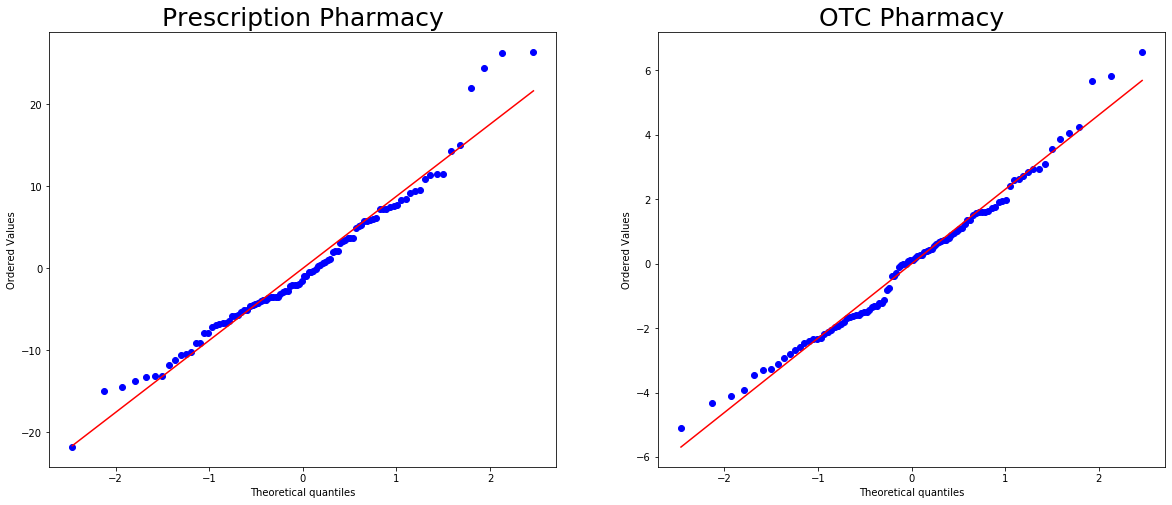

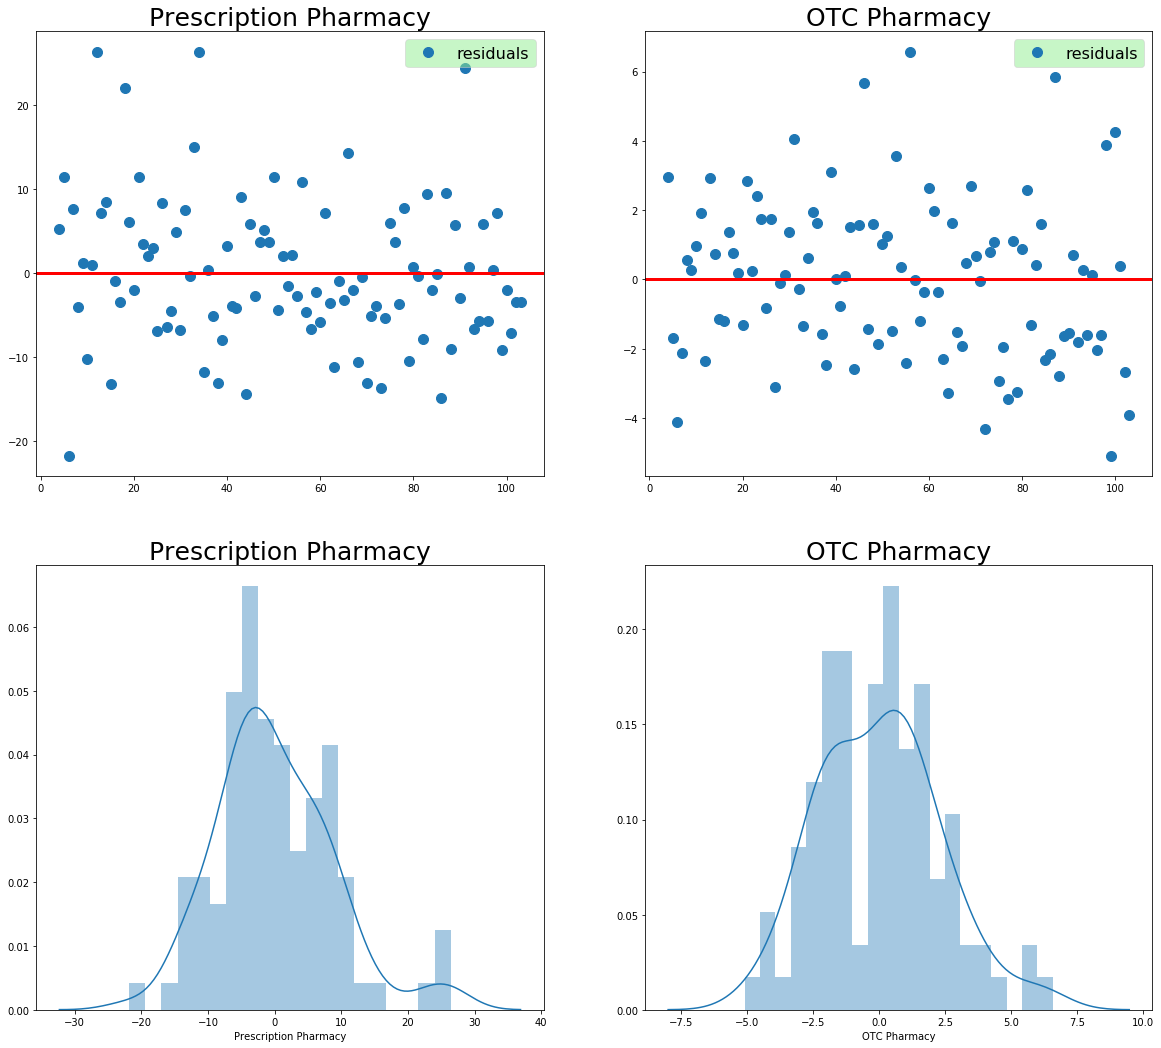

Prescription Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.011620068922638893
omnibus pvalue = 0.006294349113868904
OTC Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.31627699732780457
omnibus pvalue = 0.29654003667521617
Prescription Pharmacy ljung-box pvalue = [0.23512156 0.35005368 0.45079118 0.53346665 0.66525306 0.74331926
 0.77187905 0.84041912 0.81117461 0.84124859]
OTC Pharmacy ljung-box pvalue = [0.08032445 0.08386172 0.12627201 0.21751162 0.31416237 0.42271329
 0.52544021 0.63076363 0.68448551 0.73762361]


In [32]:
residuals = model4.resid.T
plt.figure(figsize = (20,8))
stats.probplot(residuals.iloc[0], dist="norm", plot=plt.subplot(121))
plt.title("Prescription Pharmacy", size = 25)
stats.probplot(residuals.iloc[1], dist="norm", plot=plt.subplot(122))
plt.title("OTC Pharmacy", size = 25)
plt.savefig(figure_path + "qqplot_var4_dummy_nonlinearity.jpg")
plt.show()
    
plt.figure(figsize = (20,18))
plt.subplot(221)
plt.plot(residuals.iloc[0], ".", markersize = 20)
plt.axhline(0, color = "red", lw = 3)
plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
plt.title("Prescription Pharmacy", size = 25)
plt.subplot(222)
plt.plot(residuals.iloc[1], ".", markersize = 20)
plt.axhline(0, color = "red", lw = 3)
plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
plt.title("OTC Pharmacy", size = 25)
plt.subplot(223)
sns.distplot(residuals.iloc[0], bins = 20)
plt.title("Prescription Pharmacy", size = 25)
plt.subplot(224)
sns.distplot(residuals.iloc[1], bins = 20)
plt.title("OTC Pharmacy", size = 25)
plt.savefig(figure_path + "reszty_var4_dummy_nonlinearity.jpg")
plt.show()

stat_tests_resid(model4)

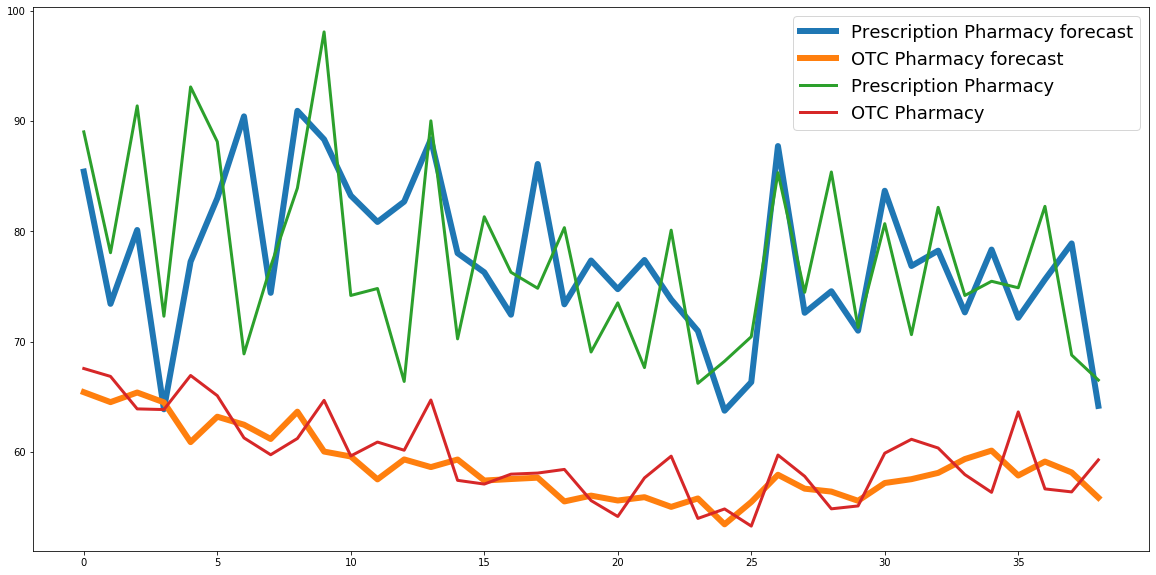

In [33]:
forecasts4 = rolling_window(X = endog.values[4:,], var = True, exog_data = X4,
                            plt_save_path = figure_path + "var4_dummy_nonlinearity_rolling_window.png")

## Random Walk forecasts

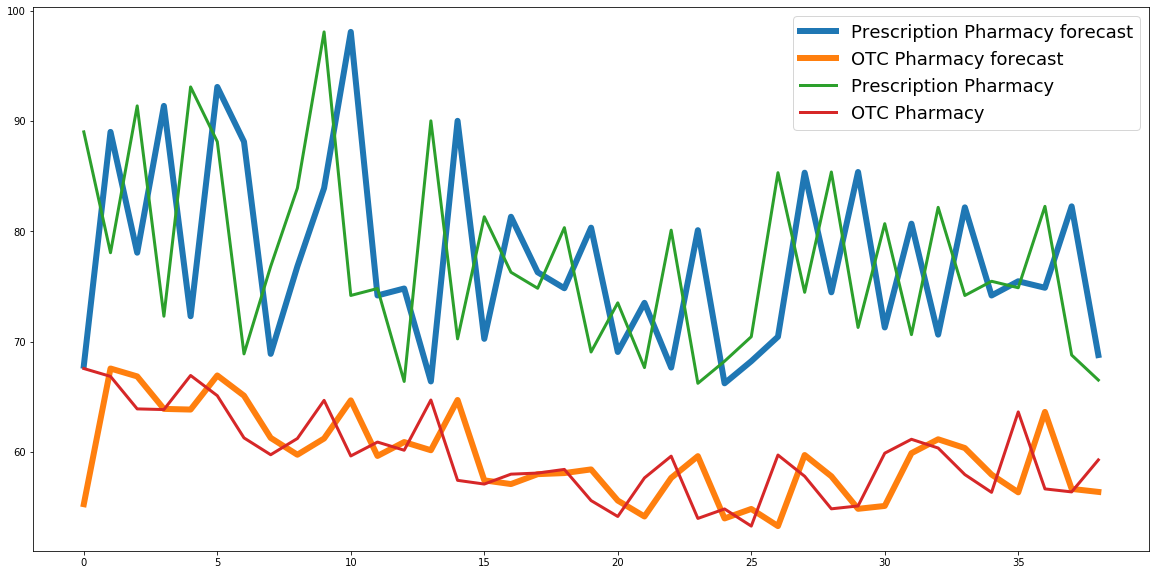

In [56]:
forecasts0 = endog[TRAIN_SIZE-1:-1]
residuals = endog_test.values - forecasts0.values
#plt.plot(forecasts)
plt.figure(figsize = (20, 10))
plt.plot(forecasts0.values, lw = 6)
plt.plot(endog_test.values, lw = 3)
plt.legend(labels = ["Prescription Pharmacy forecast", "OTC Pharmacy forecast", "Prescription Pharmacy",
                         "OTC Pharmacy"], fontsize = 18)

plt.savefig(figure_path + "random_walk_rolling_window.png")
plt.show()

In [ ]:
forecasts1 = rolling_window(X = endog.values[4:,], var = True, exog_data = X1,
                            plt_save_path = figure_path + "var4_zwykly_rolling_window.png")
forecasts2 = rolling_window(X = endog.values[4:,], var = True, exog_data = X2, plot = False)
#forecasts3 = rolling_window(X = endog.values[1:,], var_order = 1, var = True, exog_data = X3, plot = False)
forecasts4 = rolling_window(X = endog.values[4:,], var = True, exog_data = X4, plot = False)

In [47]:
# Relative MAE

# 0 - random walk
# 1 - VAR(4)
# 2 - VAR(4) 0-1
# 4 - VAR(4) 0-1, kwadarty

rel_mae0 = np.mean(np.abs(residuals) / endog_test.values, axis = 0)
rel_mae1 = np.mean(np.abs(forecasts1 - endog_test.values) / endog_test.values, axis = 0)
rel_mae2 = np.mean(np.abs(forecasts2 - endog_test.values) / endog_test.values, axis = 0)
rel_mae4 = np.mean(np.abs(forecasts4 - endog_test.values) / endog_test.values, axis = 0)

# MAE

mae0 = np.mean(np.abs(residuals), axis = 0)
mae1 = np.mean(np.abs(forecasts1 - endog_test.values), axis = 0)
mae2 = np.mean(np.abs(forecasts2 - endog_test.values), axis = 0)
mae4 = np.mean(np.abs(forecasts4 - endog_test.values), axis = 0)


# MSE

mse0 = np.mean((residuals) ** 2, axis = 0)
mse1 = np.mean((forecasts1 - endog_test.values) ** 2, axis = 0)
mse2 = np.mean((forecasts2 - endog_test.values) ** 2, axis = 0)
mse4 = np.mean((forecasts4 - endog_test.values) ** 2, axis = 0)


# Relative MSE

rel_mse0 = np.mean((residuals / endog_test.values) ** 2, axis = 0)
rel_mse1 = np.mean(((forecasts1 - endog_test.values) / endog_test.values) ** 2, axis = 0)
rel_mse2 = np.mean(((forecasts2 - endog_test.values) / endog_test.values) ** 2, axis = 0)
rel_mse4 = np.mean(((forecasts4 - endog_test.values) / endog_test.values) ** 2, axis = 0)


In [48]:
mae0, mae1, mae2, mae4

(array([10.3856441 ,  2.80659179]), Prescription Pharmacy    5.783194
 OTC Pharmacy             2.516468
 dtype: float64, Prescription Pharmacy    5.900892
 OTC Pharmacy             2.178759
 dtype: float64, Prescription Pharmacy    6.440666
 OTC Pharmacy             2.214171
 dtype: float64)

In [49]:
rel_mae0, rel_mae1, rel_mae2, rel_mae4

(array([0.13343441, 0.04663374]), Prescription Pharmacy    0.076379
 OTC Pharmacy             0.041936
 dtype: float64, Prescription Pharmacy    0.076828
 OTC Pharmacy             0.035987
 dtype: float64, Prescription Pharmacy    0.084402
 OTC Pharmacy             0.036581
 dtype: float64)

In [50]:
mse0, mse1, mse2, mse4

(array([149.95647658,  14.51360493]), Prescription Pharmacy    56.876407
 OTC Pharmacy              8.865526
 dtype: float64, Prescription Pharmacy    52.578293
 OTC Pharmacy              7.188589
 dtype: float64, Prescription Pharmacy    61.794476
 OTC Pharmacy              7.306332
 dtype: float64)

In [51]:
rel_mse0, rel_mse1, rel_mse2, rel_mse4

(array([0.02463373, 0.00388131]), Prescription Pharmacy    0.010113
 OTC Pharmacy             0.002394
 dtype: float64, Prescription Pharmacy    0.009017
 OTC Pharmacy             0.001899
 dtype: float64, Prescription Pharmacy    0.010989
 OTC Pharmacy             0.001925
 dtype: float64)

In [ ]:
print(model1_varmax.summary())
print(model2_varmax.summary())

,Prescription Pharmacy,OTC Pharmacy
0,88.780161,59.386734
1,78.469023,61.393371
2,75.737035,62.026402
3,65.711095,60.579710
4,81.463228,63.115028
5,87.107013,65.527618
6,85.891794,63.310619
7,73.673630,61.665353
8,89.644023,63.367569
9,87.771553,61.965327


In [ ]:
print("model1")
residuals_analysis(model1)
print("model2\n")
residuals_analysis(model2)
print("model3\n")
residuals_analysis(model3)
print("model4\n")
residuals_analysis(model4)


In [ ]:
stat_tests_resid(model1)
print()
stat_tests_resid(model2)
print()
stat_tests_resid(model3)
print()
stat_tests_resid(model4)


## OLS,...

In [ ]:
b_hat = np.linalg.inv(X.T @ X) @ X.T @ yo

s = ((yo.T @ yo - (np.linalg.inv(X.T @ X) @ X.T @ yo).T @ (X.T @ yo)) / 91)**0.5

V_b = s**2 * np.linalg.inv(X.T @ X)

sd_b =np.sqrt(np.diag(V_b))


for i,j in zip(b_hat, sd_b):
    print("Beta:", i, j, abs(i/j))
print(s)

In [ ]:
print(VAR(endog[4:TRAIN_SIZE], exog = X[:,1:]).fit(0, trend = "c").summary())
VAR(endog[:TRAIN_SIZE]).fit(4).llf

## Multicollinearity check

In [ ]:
X_norm = X2 / np.sqrt(np.sum(X2**2, axis = 0))
m = X_norm.T @ X_norm
print(m.shape)
eigvals = np.linalg.eigvals(m)
print(np.sqrt(max(eigvals) / min(eigvals)))
print(len(m[m>0.99])-21)
print(eigvals)

np.linalg.eig(X2.T @ X2)[0]
np.sqrt(np.sum(X2**2, axis = 0))

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for i in range(1,21):
    print(i, variance_inflation_factor(exog = X2, exog_idx = i))